In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt 

In [3]:
import numpy as np

In [4]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import average_precision_score

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
%%capture
!wget https://www.dropbox.com/s/io67uppgq66plbp/training_data.csv
!wget https://www.dropbox.com/s/2ga9maqxbsf8xhg/test_data.csv

In [8]:
training_data = pd.read_csv('training_data.csv')

In [9]:
training_data.head(10)

training_data.sample(10)

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         40147 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    48667 non-null  float64
dtypes: float64(4), 

In [10]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,50000.0,0.066860,0.249782,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,50000.0,7.927880,332.393142,0.0,0.030096,0.154426,0.555651,50708.0
age,50000.0,52.240520,14.766593,21.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,50000.0,0.428220,4.269296,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,50000.0,352.441921,2006.426016,0.0,0.176304,0.366811,0.862599,329664.0
MonthlyIncome,40147.0,6642.232222,18122.708690,0.0,3400.000000,5400.000000,8250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,50000.0,8.476040,5.172756,0.0,5.000000,8.000000,11.000000,57.0
NumberOfTimes90DaysLate,50000.0,0.269920,4.243110,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,50000.0,1.017500,1.120151,0.0,0.000000,1.000000,2.000000,32.0
NumberOfTime60-89DaysPastDueNotWorse,50000.0,0.246040,4.231055,0.0,0.000000,0.000000,0.000000,98.0


## 2. Обработать данные перед обучением модели

In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         40147 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    48667 non-null  float64
dtypes: float64(4), 

In [12]:
train_mean = training_data.mean()
train_mean

SeriousDlqin2yrs                           0.066860
RevolvingUtilizationOfUnsecuredLines       7.927880
age                                       52.240520
NumberOfTime30-59DaysPastDueNotWorse       0.428220
DebtRatio                                352.441921
MonthlyIncome                           6642.232222
NumberOfOpenCreditLinesAndLoans            8.476040
NumberOfTimes90DaysLate                    0.269920
NumberRealEstateLoansOrLines               1.017500
NumberOfTime60-89DaysPastDueNotWorse       0.246040
NumberOfDependents                         0.756180
dtype: float64

In [13]:
training_data.fillna(train_mean, inplace=True)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         50000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    50000 non-null  float64
dtypes: float64(4), 

In [14]:
target_variable_name = 'SeriousDlqin2yrs'

In [15]:
training_data[target_variable_name].value_counts()

SeriousDlqin2yrs
0    46657
1     3343
Name: count, dtype: int64

In [16]:
training_values = training_data[target_variable_name]

In [17]:
training_values.shape

(50000,)

In [18]:
training_points = training_data.drop(target_variable_name, axis=1)

In [19]:
training_data.shape

(50000, 11)

##   3. Обучить модель на обучающей выборке

In [20]:
from sklearn import linear_model, ensemble

In [21]:
logistic_regression_model = linear_model.LogisticRegression()

In [22]:
logistic_regression_model

LogisticRegression()

Создадим модель в переменной ```random_forest_model``` с параметром ```n_estimators=100```.

In [23]:
random_forest_model = ensemble.RandomForestClassifier(n_estimators=200)

In [24]:
random_forest_model

RandomForestClassifier(n_estimators=200)

In [25]:
logistic_regression_model.fit(training_points, training_values)

LogisticRegression()

In [26]:
random_forest_model.fit(training_points, training_values)

RandomForestClassifier(n_estimators=200)

## 4. Загрузить и предобработать данные для тестирования

In [27]:
test_data = pd.read_csv('test_data.csv')

In [28]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      37500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  37500 non-null  float64
 2   age                                   37500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  37500 non-null  int64  
 4   DebtRatio                             37500 non-null  float64
 5   MonthlyIncome                         30044 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       37500 non-null  int64  
 7   NumberOfTimes90DaysLate               37500 non-null  int64  
 8   NumberRealEstateLoansOrLines          37500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  37500 non-null  int64  
 10  NumberOfDependents                    36521 non-null  float64
dtypes: float64(4), 

In [29]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,37500.0,0.067387,0.250694,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,37500.0,6.031470,201.538421,0.0,0.029634,0.155112,0.565469,18300.0
age,37500.0,52.367387,14.769995,0.0,41.000000,52.000000,63.000000,107.0
NumberOfTime30-59DaysPastDueNotWorse,37500.0,0.448613,4.478678,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,37500.0,341.402289,1131.165077,0.0,0.173310,0.365951,0.866864,60212.0
MonthlyIncome,30044.0,6571.071295,7639.608316,0.0,3383.000000,5374.500000,8200.000000,562466.0
NumberOfOpenCreditLinesAndLoans,37500.0,8.428587,5.143302,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,37500.0,0.292667,4.458953,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,37500.0,1.020160,1.152043,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,37500.0,0.266160,4.444065,0.0,0.000000,0.000000,0.000000,98.0


**Шаг 4.2. Предобработка данных для тестирования**

In [30]:
test_mean = test_data.mean()
test_mean

SeriousDlqin2yrs                           0.067387
RevolvingUtilizationOfUnsecuredLines       6.031470
age                                       52.367387
NumberOfTime30-59DaysPastDueNotWorse       0.448613
DebtRatio                                341.402289
MonthlyIncome                           6571.071295
NumberOfOpenCreditLinesAndLoans            8.428587
NumberOfTimes90DaysLate                    0.292667
NumberRealEstateLoansOrLines               1.020160
NumberOfTime60-89DaysPastDueNotWorse       0.266160
NumberOfDependents                         0.753512
dtype: float64

In [31]:
test_data.fillna(test_mean, inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      37500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  37500 non-null  float64
 2   age                                   37500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  37500 non-null  int64  
 4   DebtRatio                             37500 non-null  float64
 5   MonthlyIncome                         37500 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       37500 non-null  int64  
 7   NumberOfTimes90DaysLate               37500 non-null  int64  
 8   NumberRealEstateLoansOrLines          37500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  37500 non-null  int64  
 10  NumberOfDependents                    37500 non-null  float64
dtypes: float64(4), 

In [32]:
target_variable_name = 'SeriousDlqin2yrs'

**Шаг 4.3. Отделяем целевую переменную**

In [33]:
test_values = test_data[target_variable_name]
test_values.shape

(37500,)

In [34]:
test_points = test_data.drop(target_variable_name, axis=1)

In [35]:
test_points.shape # (37500, 10)

(37500, 10)

# 5. Провалидировать модель на тестовой выборке

In [36]:
test_predictions_logistic_regression = logistic_regression_model.predict(test_points)

In [37]:
test_predictions_random_forest = random_forest_model.predict(test_points)

In [38]:
counts_lr = pd.Series(test_predictions_logistic_regression).value_counts()
counts_rf = pd.Series(test_predictions_random_forest).value_counts()

print("Логистическая регрессия:")
print(counts_lr)

print("\nСлучайный лес:")
print(counts_rf)

Логистическая регрессия:
0    37436
1       64
Name: count, dtype: int64

Случайный лес:
0    36620
1      880
Name: count, dtype: int64


### Шаг 5.1. Точность прогноза

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
# Вычисление точности предсказаний
lr_accuracy = accuracy_score(test_values, test_predictions_logistic_regression)
rf_accuracy = accuracy_score(test_values, test_predictions_random_forest)

print("Точность модели логистической регрессии:")
print(round(lr_accuracy, 5))

print("\nТочность модели случайного леса:")
print(round(rf_accuracy, 5))

Точность модели логистической регрессии:
0.93245

Точность модели случайного леса:
0.93464


**Как понять, хорошо работает модель или нет?**

In [41]:
accuracy = accuracy_score(test_values, np.zeros_like(test_values))
print(round(accuracy, 5))

0.93261


### Шаг 5.2. Таблица сопряженности модели классификации

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
logistic_regression_confusion_matrix = confusion_matrix(test_values, test_predictions_logistic_regression)
logistic_regression_confusion_matrix = pd.DataFrame(logistic_regression_confusion_matrix)

logistic_regression_confusion_matrix

,0,1
0,34938,35
1,2498,29


In [44]:
random_forest_confusion_matrix = confusion_matrix(test_values, test_predictions_random_forest)
random_forest_confusion_matrix = pd.DataFrame(random_forest_confusion_matrix)

random_forest_confusion_matrix

,0,1
0,34571,402
1,2049,478


### Шаг 5.3. Прогноз вероятности принадлежности к классу

In [45]:
test_probabilities = logistic_regression_model.predict_proba(test_points)

In [46]:
test_probabilities[:5, :]

array([[0.82039116, 0.17960884],
       [0.83653007, 0.16346993],
       [0.94724556, 0.05275444],
       [0.88775259, 0.11224741],
       [0.92403297, 0.07596703]])

In [47]:
test_probabilities = test_probabilities[:, 1]

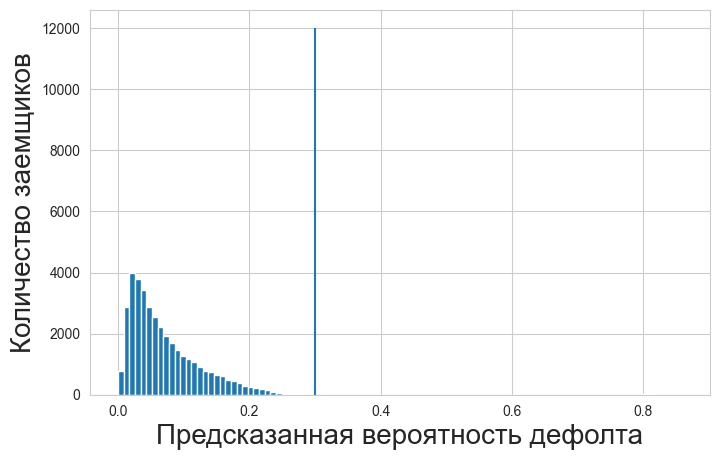

In [48]:
plt.figure(figsize=(8, 5))

plt.hist(test_probabilities, bins=100)
plt.vlines(0.3, 0, 12000)

plt.xlabel('Предсказанная вероятность дефолта', fontsize=20)
plt.ylabel('Количество заемщиков', fontsize=20);

### Шаг 5.4. Выбор порога классификатора

In [49]:
higher_thershold = 0.7
alternative_test_predictions = test_probabilities > higher_thershold

In [50]:
alternative_confusion_matrix = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions))
alternative_confusion_matrix

,0,1
0,34947,26
1,2508,19


In [51]:
thresholds = [0.3, 0.5, 0.7]

confusion_matrices_lr = {}
confusion_matrices_rf = {}

test_probabilities_lr = logistic_regression_model.predict_proba(test_points)

for threshold in thresholds:
    predictions = (test_probabilities_lr[:, 1] > threshold).astype(int)
    confusion_matrix_result = confusion_matrix(test_values, predictions)
    confusion_matrices_lr[threshold] = confusion_matrix_result

test_probabilities_rf = random_forest_model.predict_proba(test_points)

for threshold in thresholds:
    predictions = (test_probabilities_rf[:, 1] > threshold).astype(int)
    confusion_matrix_result = confusion_matrix(test_values, predictions)
    confusion_matrices_rf[threshold] = confusion_matrix_result

print('Матрицы для логистической регрессии:')
for threshold in thresholds:
    print(f"Порог: {threshold}")
    print(pd.DataFrame(confusion_matrices_lr[threshold], columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]))
    print('\n')

print('Матрицы для случайного леса:')
for threshold in thresholds:
    print(f"Порог: {threshold}")
    print(pd.DataFrame(confusion_matrices_rf[threshold], columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]))
    print('\n')

Матрицы ошибок для модели логистической регрессии:
Порог: 0.3
          Predicted 0  Predicted 1
Actual 0        34925           48
Actual 1         2483           44


Порог: 0.5
          Predicted 0  Predicted 1
Actual 0        34938           35
Actual 1         2498           29


Порог: 0.7
          Predicted 0  Predicted 1
Actual 0        34947           26
Actual 1         2508           19


Матрицы ошибок для модели случайного леса:
Порог: 0.3
          Predicted 0  Predicted 1
Actual 0        33573         1400
Actual 1         1535          992


Порог: 0.5
          Predicted 0  Predicted 1
Actual 0        34571          402
Actual 1         2049          478


Порог: 0.7
          Predicted 0  Predicted 1
Actual 0        34916           57
Actual 1         2401          126




### *Бонус:  ROC кривая классификатора

In [66]:
test_probabilities_lr = logistic_regression_model.predict_proba(test_points)[:, 1]
false_positive_rates_lr, true_positive_rates_lr, threshold_lr = roc_curve(test_values, test_probabilities_lr)

test_probabilities_rf = random_forest_model.predict_proba(test_points)[:, 1]

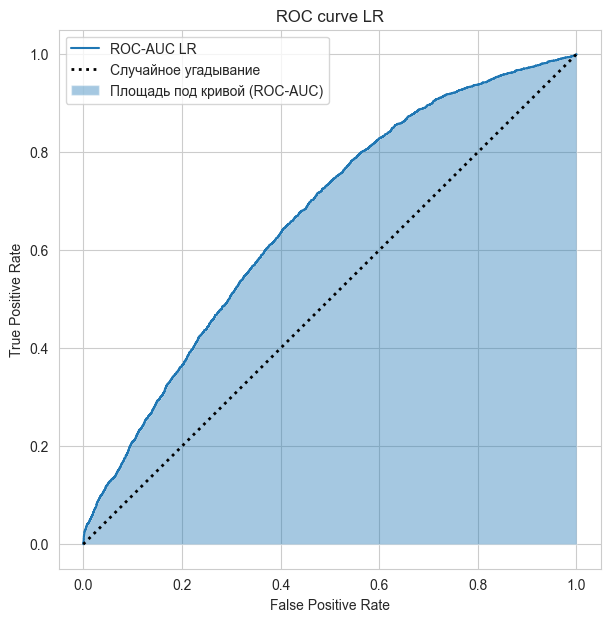

In [70]:
plt.figure(figsize=(7, 7))
plt.plot(false_positive_rates_lr, true_positive_rates_lr, label='ROC-AUC LR')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Случайное угадывание')
plt.fill_between(false_positive_rates_lr, true_positive_rates_lr, step="mid", alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.title('ROC curve LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

Вычислите значения *roc_auc_value* для обеих моделей

In [73]:
from sklearn.metrics import roc_auc_score
roc_auc_lr = roc_auc_score(test_values, test_probabilities_lr)
print(f"ROC-AUC - логистической регрессии: {roc_auc_lr:.4f}")

roc_auc_rf = roc_auc_score(test_values, test_probabilities_rf)
print(f"ROC-AUC - случайного леса: {roc_auc_rf:.4f}")

ROC-AUC - логистической регрессии: 0.6618
ROC-AUC - случайного леса: 0.8442
